In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (12,7)

## Step 0
### Data Acquisition

In [2]:
tickers_market = ['SPY']
tickers_energy = ['XLE', 'XOP']
tickers_gold = ['GDX', 'GLD']
tickers_tech = ['IYW', 'XLK']

start = '2017-01-01'
end = '2022-01-01'

data_market = yf.download(tickers_market, start=start, end=end, progress=False, auto_adjust=True)["Close"] # pyright: ignore[reportOptionalSubscript] 
data_energy = yf.download(tickers_energy, start=start, end=end, progress=False, auto_adjust=True)["Close"] # pyright: ignore[reportOptionalSubscript] 
data_gold = yf.download(tickers_gold, start=start, end=end, progress=False, auto_adjust=True)["Close"] # pyright: ignore[reportOptionalSubscript] 
data_tech = yf.download(tickers_tech, start=start, end=end, progress=False, auto_adjust=True)["Close"]  # type: ignore

prices = pd.concat([data_market, data_energy, data_gold, data_tech], axis=1)
rets = pd.DataFrame(np.log(prices / prices.shift(1))).dropna()
rets

Ticker,SPY,XLE,XOP,GDX,GLD,IYW,XLK
Date,,,,,,,
2017-01-04,0.005932,-0.002103,0.004749,0.007326,0.003524,0.004447,0.003478
2017-01-05,-0.000795,-0.002503,-0.003084,0.056753,0.015396,0.001560,0.001633
2017-01-06,0.003571,0.000923,-0.007394,-0.035538,-0.007400,0.009473,0.007314
2017-01-09,-0.003306,-0.014601,-0.028411,0.003121,0.008199,0.002841,-0.000202
2017-01-10,0.000000,-0.009134,0.000000,0.007099,0.004251,0.000324,0.000202
...,...,...,...,...,...,...,...
2021-12-27,0.014053,0.021622,0.039652,0.000958,0.002364,0.020187,0.021225
2021-12-28,-0.000817,-0.000714,-0.008699,-0.007690,-0.004319,-0.008060,-0.005222
2021-12-29,0.001278,-0.006442,-0.004072,0.004173,-0.000297,-0.000431,0.000853


In [3]:
rets["SPY"].describe()

count    1258.000000
mean        0.000663
std         0.011944
min        -0.115886
25%        -0.002942
50%         0.000920
75%         0.005883
max         0.086731
Name: SPY, dtype: float64

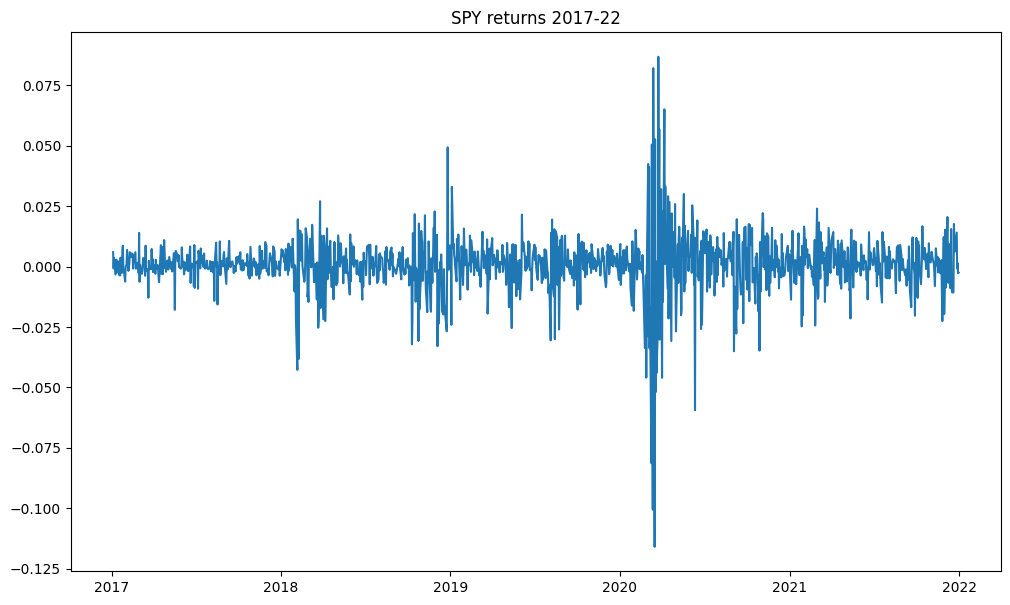

In [4]:
plt.plot(rets["SPY"])
plt.title("SPY returns 2017-22")

plt.show()

## Step 1
### Foundational Analysis, part C: identify volatility regimes in SPY using a Markov Switching AutoRegressive (MS-AR) model

In [5]:
mod_spy = sm.tsa.MarkovAutoregression(rets["SPY"], k_regimes=2, order=1, trend='c', switching_ar=True, switching_variance=True)

In [6]:
# halflife
tau_days = np.array([10.5, 21]) # observing SPY returns half-revert in 10 days when low vol, 21 when high vol
business_year_in_days = 252
tau = tau_days / business_year_in_days
# UO's mean reversion adapted to AR(1)'s beta
log2 = np.log(2)
kappa = log2 / tau
beta = np.exp(-kappa / business_year_in_days)

# rough estimation of logit^-1(transition probabilities)
P = np.array([0.9, 0.5])
logit = np.exp(P)/(1 + np.exp(P))

In [7]:
# parameter layout:
#  0,1   → alpha_0, alpha_1          (intercepts)
#  2,3   → phi_0, phi_1          (AR(1) beta's)
#  4,5   → sigma_0, sigma_1        (variances)
#  6,7   → unconstrained elements of P (logit‑scale)

start = mod_spy.start_params.copy()
start[:2] = logit       # logit(P)       # mu guesses: calm 20 bp, stress 200 bp
start[2:4] = [0.0005, -0.0010]  # mu          # beta guesses: kappa approx 2.3 /yr vs 1.0 /yr
start[4:6] = [0.008, 0.02]           # sigma guesses
# logit(P00) ~ 2.5  -> P00 approx 0.92 ; logit(P11) ~ 0   -> P11 approx 0.5
start[6:8] = beta  # beta
# start[:2] = [0.0005, -0.0010]  # mu          # beta guesses: kappa approx 2.3 /yr vs 1.0 /yr
# start[2:4] = beta  # beta
# start[4:6] = [0.008, 0.02]           # sigma guesses
# # # logit(P00) ~ 2.5  -> P00 approx 0.92 ; logit(P11) ~ 0   -> P11 approx 0.5
# start[6:8] = logit       # logit(P)       # mu guesses: calm 20 bp, stress 200 bp

# bounds:   alpha ≥ 0,   0.70 <= beta <= 0.95,   sigma ≥ 1e‑3,   transition logits free
b = [(0.25, 0.931), (0.25, 0.931), #(0.5, 0.731), (0.5, 0.731), # P         # mu
	(-0.01, 0.01), (-0.01, 0.01), # mu   # beta
	(1e-3, 1e6), (1e-3, 1e6),    # sigma
	(0.50, 1.3), (0.50, 1.3)]  #beta  # logits of P
# b = [
# 	(-0.01, 0.01), (-0.01, 0.01), # mu   # beta
# 	(0.70, 1.1), (0.70, 1.1), #beta
# 	(1e-3, 1e6), (1e-3, 1e6),    # sigma
#     (0, 1e6), (0, 1e6),
# 	#(0.25, 0.931), (0.25, 0.931) # P         # mu
# ] 

np.random.seed(1234)
spy_markov_results = mod_spy.fit(start_params=start, bounds=b, method="bfgs", maxiter=500, search_reps=20) # bounds=b,
#spy_markov_results = mod_spy.fit(search_reps=20)

In [8]:
print( spy_markov_results.summary() )

                         Markov Switching Model Results                         
Dep. Variable:                      SPY   No. Observations:                 1257
Model:             MarkovAutoregression   Log Likelihood                4238.063
Date:                  Wed, 17 Sep 2025   AIC                          -8460.125
Time:                          05:12:34   BIC                          -8419.033
Sample:                               0   HQIC                         -8444.682
                                 - 1257                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0012      0.001     -1.255      0.210      -0.003       0.001
sigma2         0.0004   3.91e-05    

In [9]:
spy_markov_results.params

p[0->0]      0.936024
p[1->0]      0.023227
const[0]    -0.001159
const[1]     0.001359
sigma2[0]    0.000416
sigma2[1]    0.000029
ar.L1[0]    -0.261290
ar.L1[1]    -0.046090
dtype: float64

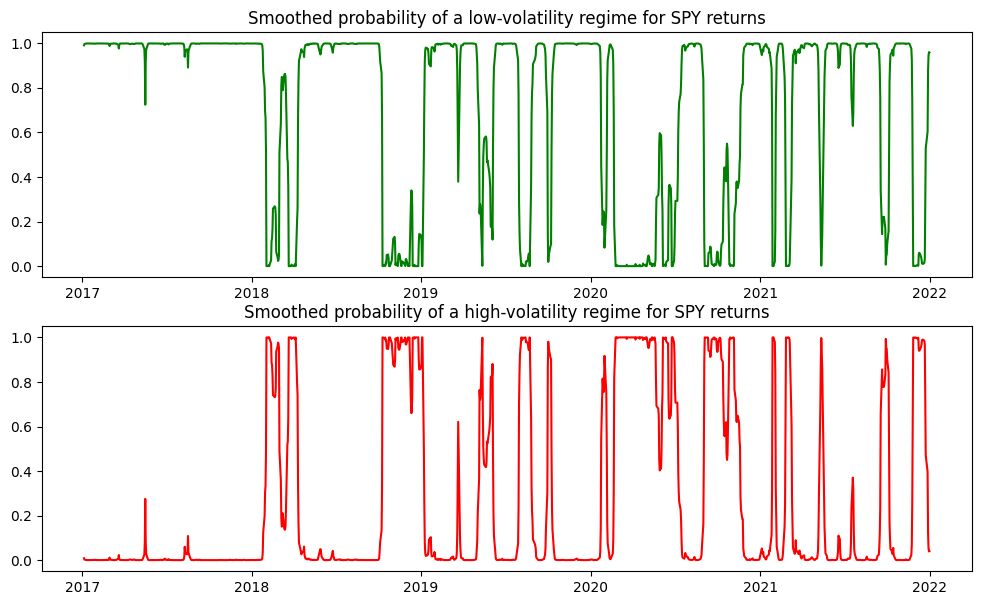

In [13]:
fig, axes = plt.subplots(2)

ax = axes[0]
ax.plot(spy_markov_results.smoothed_marginal_probabilities[1],'g')
ax.set(title="Smoothed probability of a low-volatility regime for SPY returns")

ax = axes[1]
ax.plot(spy_markov_results.smoothed_marginal_probabilities[0],'r')
ax.set(title="Smoothed probability of a high-volatility regime for SPY returns")
plt.show()

In [14]:
print("Average duration of each regime:")
print(f"Calm regime: {spy_markov_results.expected_durations[1]:.3f}  days\nStressed regime:  {spy_markov_results.expected_durations[0]:.3f} days")

Average duration of each regime:
Calm regime: 43.054  days
Stressed regime:  15.631 days
